# IEEE-CIS FRAUD DETECTION

A dataset provided by IEEE on email fraud detection will be used to create a model that will be able to successfully classify the email frauds.

## Dataset
- test_identity.csv
- test_transaction.csv
- train_identity.csv
- train_transaction.csv

# Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestClassifier
import time
import xgboost as xgb
import warnings
import pickle
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='seaborn')
%matplotlib inline

In [2]:
pip install xgboost

In [2]:
#from google.colab import drive

#drive.mount('/content/drive')

In [2]:
test_identity = pd.read_csv("test_identity.csv")
train_identity = pd.read_csv("train_identity.csv")
test_transaction = pd.read_csv("test_transaction.csv")
train_transaction = pd.read_csv("train_transaction.csv")

In [ ]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left') 

# Visualizing the Data

In [ ]:
print(train.info())
print(test.info())

In [ ]:
train.describe()

In [ ]:
test.describe()

In [ ]:
train.head()

In [ ]:
test.head()

In [5]:
def differentcolumns(traincols, testcols):
  """
  Input: Takes in two columns, one from train set another from test set
  Output: Shows the column names which are not same in both sets

  """
  for i in traincols:
    if i not in testcols:
      print(i)
      
#differentcolumns(train.columns, test.columns)

#### Is fraud is the `class` column. Thus, it is obvious it won't be visible in the testing dataset. We will change the corresponding names of the columns in the testing dataset so that the name matches in both the data sets

In [37]:
test = test.rename(columns={"id-01": "id_01", "id-02": "id_02", "id-03": "id_03",
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04",
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09",
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12",
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13",
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18",
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19",
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24",
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25",
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30",
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33",
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36",
                            "id-37": "id_37", "id-38": "id_38"})
test.head()

,H,R,S,W,discover,mastercard,visa,credit,debit,debit or credit,Unnamed: 0,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,0,0,1,1,0,0,1,0,0,0.0,3663549.0,18403224.0,31.95,10409.0,111.0,150.0,226.0,170.0,87.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,398.0,418.0,409.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,1,0,1,0,0,1.0,3663550.0,18403263.0,49.00,4272.0,111.0,150.0,226.0,299.0,87.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,634.0,231.0,634.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0,0,1,0,1,0,2.0,3663551.0,18403310.0,171.00,4476.0,574.0,150.0,226.0,472.0,87.0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,97.0,136.0,97.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,968.000000,0.000000,0.000000,705.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,0,0,0,1,0,1,0,0,1,0,3.0,3663552.0,18403310.0,284.95,10989.0,360.0,150.0,166.0,205.0,87.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,242.0,242.0,242.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0

In [38]:
# Counting total NaN at each column 
train_null = train.isnull().sum()
test_null = test.isnull().sum()
print(" \nTotal NaN at each column in a Train set : \n\n", train_null)
print(" \nTotal NaN at each column in a Test set : \n\n", test_null)

 
Total NaN at each column in a Train set : 

 H            0
R            0
S            0
W            0
discover     0
            ..
V317        12
V318        12
V319        12
V320        12
V321        12
Length: 209, dtype: int64
 
Total NaN at each column in a Test set : 

 H               0
R               0
S               0
W               0
discover        0
            ...  
V317        83852
V318        83852
V319        83852
V320        83852
V321        83852
Length: 208, dtype: int64


### As we can see that here is a very high number of null values in each column, and a better way to see it will be using visualizations.

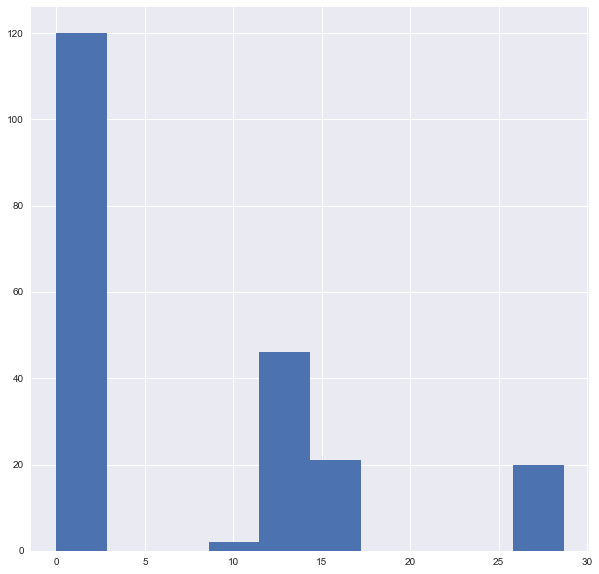

In [39]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.figure(figsize=(10,10))
plt.hist(train.isnull().sum()*100/len(train))
plt.show()

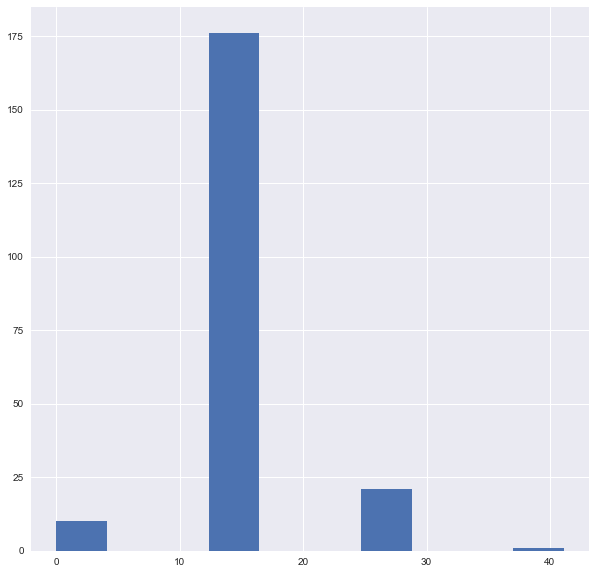

In [40]:
plt.figure(figsize=(10,10))
plt.hist(test.isnull().sum()*100/len(test))
plt.show()

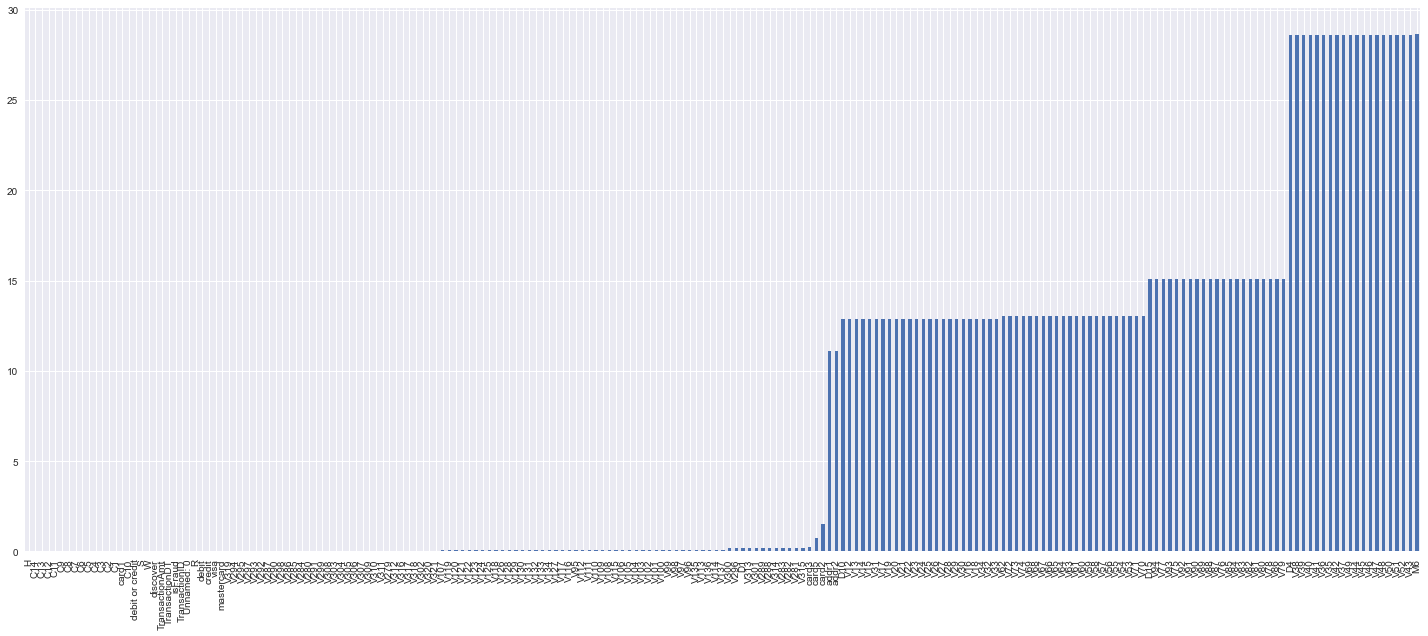

In [41]:
# Investigating patterns in the amount of missing data in each column.
temp1=train.isnull().sum()*100/len(train)
temp_train = temp1.sort_values()
plt.figure(figsize=(25,10))
temp_train.plot.bar();

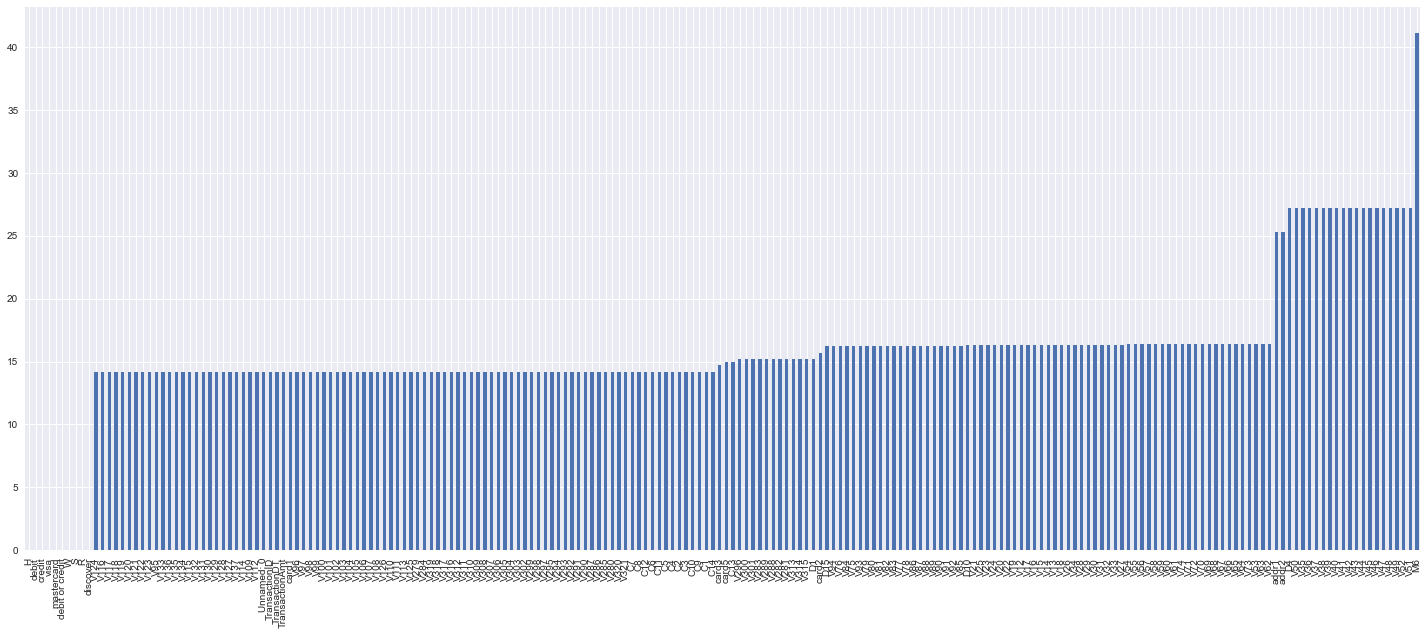

In [42]:
temp2 = test.isnull().sum()*100/len(test)
temp_test = temp2.sort_values()
plt.figure(figsize=(25,10))
temp_test.plot.bar();

### From our Visual study, we found that the threshold of 40% would be good to remove the NaN value columns. But there is a chance that different types of columns can get dumped after this operation. Thus, we will start from 40% and keep on increasing it. Until, both list of dropped columns become identical.

In [43]:
Drop = []
for x in train.columns:
    if (train[x].isnull().sum()*100/len(train)>40):
        Drop.append(x)

Drop

[]

In [1]:
train.drop(Drop, axis=1, inplace=True)
test.drop(Drop, axis=1, inplace=True) 

NameError: name 'train' is not defined

In [2]:
test = pd.read_csv('Datasets_version01/test.csv')
train = pd.read_csv('Datasets_version01/train.csv')

In [3]:
print(train.shape)
print(test.shape)

(590540, 202)
(506691, 201)


In [4]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 202 entries, Unnamed: 0 to V321
dtypes: float64(193), int64(5), object(4)
memory usage: 910.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 201 entries, Unnamed: 0 to V321
dtypes: float64(193), int64(4), object(4)
memory usage: 777.0+ MB
None


In [5]:
g = train.columns.to_series().groupby(train.dtypes).groups
g

{int64: ['Unnamed: 0', 'TransactionID', 'isFraud', 'TransactionDT', 'card1'], float64: ['TransactionAmt', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', ...], object: ['ProductCD', 'card4', 'card6', 'M6']}

In [6]:
ob = ['ProductCD', 'card4', 'card6', 'M6'] #list of object type columns

##### We will assess these columns individually to see which column needs what kind of attention.

In [7]:
train['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [8]:
train['card4'].value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

In [9]:
train['card6'].value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [10]:
train['M6'].value_counts()

F    227856
T    193324
Name: M6, dtype: int64

##### From our ovservation we have found out that one feature is a binary feature the other ones are multivariat features. We need to handle these features individually for best output.

In [11]:
train['M6'].replace(['F','T'],[1,0],inplace=True)
test['M6'].replace(['F','T'],[1,0],inplace=True)

train['M6']

0         0.0
1         0.0
2         1.0
3         1.0
4         NaN
         ... 
590535    1.0
590536    0.0
590537    0.0
590538    0.0
590539    0.0
Name: M6, Length: 590540, dtype: float64

In [12]:
df_ProductCD = pd.get_dummies(train['ProductCD'], drop_first=True)

df_ProductCD

,H,R,S,W
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,1,0,0,0
...,...,...,...,...
590535,0,0,0,1
590536,0,0,0,1
590537,0,0,0,1
590538,0,0,0,1


In [13]:
df_Card4 = pd.get_dummies(train['card4'], drop_first=True)

df_Card4

,discover,mastercard,visa
0,1,0,0
1,0,1,0
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
590535,0,0,1
590536,0,1,0
590537,0,1,0
590538,0,1,0


In [14]:
df_Card6 = pd.get_dummies(train['card6'], drop_first=True)

df_Card6

,credit,debit,debit or credit
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,1,0,0
...,...,...,...
590535,0,1,0
590536,0,1,0
590537,0,1,0
590538,0,1,0


In [15]:
train = pd.concat([df_Card6, train], axis=1)
test = pd.concat([df_Card6, test], axis=1)

In [16]:
train.head()

,credit,debit,debit or credit,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,1,0,0,0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,1,0,0,1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,315.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,94.0,84.0,111.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,28.0,0.

In [17]:
test.head()

,credit,debit,debit or credit,Unnamed: 0,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,1,0,0,0.0,3663549.0,18403224.0,31.95,W,10409.0,111.0,150.0,visa,226.0,debit,170.0,87.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,398.0,418.0,409.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1.0,3663550.0,18403263.0,49.00,W,4272.0,111.0,150.0,visa,226.0,debit,299.0,87.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,634.0,231.0,634.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,2.0,3663551.0,18403310.0,171.00,W,4476.0,574.0,150.0,visa,226.0,debit,472.0,87.0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,97.0,136.0,97.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,968.000000,0.000000,0.000000,705.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,0,1,0,3.0,3663552.0,18403310.0,284.95,W,10989.0,360.0,150.0,visa,166.0,debit,205.0,87.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,242.0,242.0,242.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.

In [18]:
train = pd.concat([df_Card4, train], axis=1)
test = pd.concat([df_Card4, test], axis=1)

In [19]:
train.head()

,discover,mastercard,visa,credit,debit,debit or credit,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,1,0,0,1,0,0,0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,0,1,0,1,0,0,1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1,0,1,0,2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,315.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,1,0,3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,94.0,84.0,111.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0

In [20]:
test.head()

,discover,mastercard,visa,credit,debit,debit or credit,Unnamed: 0,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,1,0,0,1,0,0,0.0,3663549.0,18403224.0,31.95,W,10409.0,111.0,150.0,visa,226.0,debit,170.0,87.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,398.0,418.0,409.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,1,0,0,1.0,3663550.0,18403263.0,49.00,W,4272.0,111.0,150.0,visa,226.0,debit,299.0,87.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,634.0,231.0,634.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1,0,1,0,2.0,3663551.0,18403310.0,171.00,W,4476.0,574.0,150.0,visa,226.0,debit,472.0,87.0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,97.0,136.0,97.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,968.000000,0.000000,0.000000,705.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,0,1,0,0,1,0,3.0,3663552.0,18403310.0,284.95,W,10989.0,360.0,150.0,visa,166.0,debit,205.0,87.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,242.0,242.0,242.0,0

In [21]:
train = pd.concat([df_ProductCD, train], axis=1)
test = pd.concat([df_ProductCD, test], axis=1)

In [22]:
train.head()

,H,R,S,W,discover,mastercard,visa,credit,debit,debit or credit,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,0,0,1,1,0,0,1,0,0,0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,1,0,1,0,0,1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0,0,1,0,1,0,2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,315.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,0,1,0,0,1,0,3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,94.0,84.0,111.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0

In [23]:
test.head()

,H,R,S,W,discover,mastercard,visa,credit,debit,debit or credit,Unnamed: 0,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,0,0,1,1,0,0,1,0,0,0.0,3663549.0,18403224.0,31.95,W,10409.0,111.0,150.0,visa,226.0,debit,170.0,87.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,398.0,418.0,409.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,1,0,1,0,0,1.0,3663550.0,18403263.0,49.00,W,4272.0,111.0,150.0,visa,226.0,debit,299.0,87.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,634.0,231.0,634.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0,0,1,0,1,0,2.0,3663551.0,18403310.0,171.00,W,4476.0,574.0,150.0,visa,226.0,debit,472.0,87.0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,97.0,136.0,97.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,968.000000,0.000000,0.000000,705.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,0,0,0,1,0,1,0,0,1,0,3.0,3663552.0,18403310.0,284.95,W,10989.0,360.0,150.0,visa,166.0,debit,205.0,87.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,

In [24]:
train.drop(['ProductCD', 'card4', 'card6'],axis=1,inplace=True)
test.drop(['ProductCD', 'card4', 'card6'],axis=1,inplace=True)

### Now checking what are the datatypes of the remaining features

In [25]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 209 entries, H to V321
dtypes: float64(194), int64(5), uint8(10)
memory usage: 902.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 208 entries, H to V321
dtypes: float64(198), uint8(10)
memory usage: 897.7 MB
None


In [26]:
print(train.shape)
print(test.shape)

(590540, 209)
(590540, 208)


#### As we have filled the columns on the basis of the training set the testing set also got increaded and we will delete the excessive rows

In [27]:
test = test.drop(labels=range(506690, 590540), axis=0)

In [28]:
print(train.shape)
print(test.shape)

(590540, 209)
(506690, 208)


In [29]:
 def getnulls(data):
     total = data.isnull().sum().sort_values(ascending=False)
     percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
     missing_data = pd.concat([total, percent], axis=1, keys=['total', 'precent'])
     return missing_data

In [30]:
train.describe()

,H,R,S,W,discover,mastercard,visa,credit,debit,debit or credit,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,421618.000000,514518.000000,501427.000000,421180.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000
mean,0.055922,0.063838,0.019690,0.744522,0.011263,0.320414,0.651551,0.252288,0.744976,0.000

In [31]:
train

,H,R,S,W,discover,mastercard,visa,credit,debit,debit or credit,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,0,0,1,1,0,0,1,0,0,0,2987000,0,86400,68.50,13926,NaN,150.0,142.0,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,117.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000
1,0,0,0,1,0,1,0,1,0,0,1,2987001,0,86401,29.00,2755,404.0,150.0,102.0,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0,0,0,1,0,0,1,0,1,0,2,2987002,0,86469,59.00,4663,490.0,150.0,166.0,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,315.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0,0,0,1,0,1,0,0,1,0,3,2987003,0,86499,50.00,18132,567.0,150.0,117.0,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,94.0,84.0,111.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [32]:
missing_data = getnulls(train)
missing_data.T 

,M6,V36,V35,V52,V51,V50,V49,V48,V47,V46,V45,V44,V43,V42,V41,V40,V39,V38,V37,D4,V76,V86,V75,V80,V81,V78,V82,V77,V83,V84,V85,V79,V87,V88,V89,V90,V91,V92,V93,V94,D15,V53,V74,V56,V54,V55,V72,V71,V70,V69,V68,V67,V66,V65,V63,V62,V61,V60,V59,V57,V73,V64,V58,V34,V22,V33,V12,V13,V14,V15,V17,V18,V19,V20,V21,V16,V23,V24,V25,V26,V27,V32,V28,V29,V30,V31,D10,addr2,addr1,card2,card5,card3,V289,V283,V282,V281,V315,V314,V313,V288,D1,V301,V300,V296,V108,V111,V102,V103,V104,V105,V106,V107,V125,V109,V110,V113,V112,V100,V114,V115,V116,V117,V118,V119,V120,V121,V122,V101,V98,V99,V130,V137,V136,V135,V134,V133,V124,V131,V132,V129,V128,V127,V126,V95,V96,V97,V123,V291,V290,V294,V293,V287,V304,V305,V320,V306,V303,V292,V302,V299,V307,V308,V309,V310,V311,V312,V298,V297,V295,V317,V318,V319,V316,V321,V286,V284,V280,V279,V285,debit,TransactionDT,isFraud,TransactionID,Unnamed: 0,debit or credit,visa,credit,card1,mastercard,discover,W,S,TransactionAmt,C3,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,R,H
total,169360.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168969.000000,168922.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89113.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76022.000000,65706.000000,65706.000000,8933.000000,4259.000000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.286788,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286126,0.286047,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150901,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.

In [33]:
train['M6'].head(50)

0     0.0
1     0.0
2     1.0
3     1.0
4     NaN
5     0.0
6     1.0
7     1.0
8     NaN
9     0.0
10    NaN
11    NaN
12    1.0
13    1.0
14    1.0
15    1.0
16    NaN
17    NaN
18    1.0
19    1.0
20    1.0
21    1.0
22    NaN
23    1.0
24    1.0
25    1.0
26    0.0
27    0.0
28    1.0
29    1.0
30    1.0
31    0.0
32    0.0
33    1.0
34    0.0
35    1.0
36    0.0
37    0.0
38    NaN
39    0.0
40    NaN
41    1.0
42    1.0
43    0.0
44    1.0
45    1.0
46    1.0
47    0.0
48    NaN
49    NaN
Name: M6, dtype: float64

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 209 entries, H to V321
dtypes: float64(194), int64(5), uint8(10)
memory usage: 902.2 MB


In [35]:
for x in train.columns:
    train[x] = train[x].interpolate(limit_direction='both')
    
for y in test.columns:
    test[y] = test[y].interpolate(limit_direction='both')

In [36]:
print(sum(train.isnull().sum()))
print(sum(test.isnull().sum()))

0
0


#### Now, we have imputed all the null values and have converted all the categorical values. We need to perform PCA to find out which values are essential for the result.

In [37]:
for i in train.columns:
    print(i)

H
R
S
W
discover
mastercard
visa
credit
debit
debit or credit
Unnamed: 0
TransactionID
isFraud
TransactionDT
TransactionAmt
card1
card2
card3
card5
addr1
addr2
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D4
D10
D15
M6
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V279
V280
V281
V282
V283
V284
V285
V286
V287
V288
V289
V290
V291
V292
V293
V294
V295
V296
V297
V298
V299
V300
V301
V302
V303
V304
V305
V306
V307
V308
V309
V310
V311
V312
V313
V314
V315
V316
V317
V318
V319
V320
V321


In [38]:
train.drop(['TransactionID'], axis=1, inplace=True)
test_id = test['TransactionID']
test.drop(['TransactionID'], axis=1, inplace=True)
print(train.shape)
print(test.shape) 

(590540, 208)
(506690, 207)


In [40]:
#differentcolumns(train.columns, test.columns) 

In [41]:
target = train.isFraud
train.drop(['isFraud'], axis=1, inplace=True)
print(train.shape)
print(test.shape) 

(590540, 207)
(506690, 207)


In [42]:
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [43]:
print(train.shape)
print(test.shape) 

(590540, 207)
(506690, 207)


In [44]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train,test], axis=0, sort=False)
print(all_data.shape) 

(1097230, 207)


In [45]:
### Now, we shall do PCA, which we will perform to reduce dimensions. 

In [46]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
df_transform = pd.DataFrame(scale.fit_transform(all_data))
df_transform.columns = all_data.columns

In [47]:
# Appling PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
df_pca = pca.fit_transform(df_transform)

In [48]:
def scree_plot(pca):
    num_comp = len(pca.explained_variance_ratio_)
    index = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(index, vals)
    ax.plot(index, cumvals)
    for i in range(num_comp):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (index[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

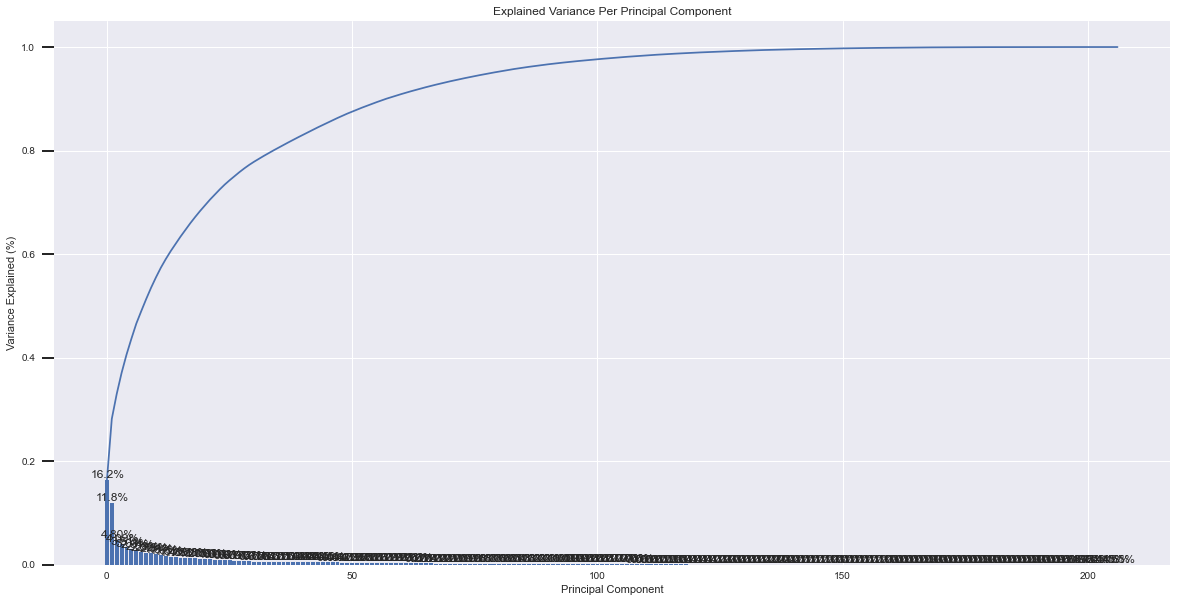

In [49]:
scree_plot(pca)

##### Here, we can see that using around 80 components we can get similar results. Thus, we shall commance with dimentionality reduction and use the 80 components. 

In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 80)
df_pca = pca.fit_transform(df_transform)

In [51]:
train = df_pca[:ntrain]
test = df_pca[ntrain:] 

In [52]:
train.shape

(590540, 80)

In [53]:
test.shape

(506690, 80)

### Now we will be training the models using the training data. For this we have chosen 3 models.

# Models
- Decision Tree
- Random Forest
- Xgboost

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm

model_params = {
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=0, class_weight= "balanced"),
        'params': {
            'criterion': ["gini", "entropy"],
            'splitter': ["best", "random"],
            'max_features': ["auto", "sqrt", "log2"]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=0),
        'params': {
            'criterion': ["gini", "entropy"],
            'max_features': ["auto", "sqrt", "log2"],
            'class_weight': ["balanced", "balanced_subsample"]
        }
    },
    ' xgb.XGBClassifier': {
        'model': xgb.XGBClassifier(subsample=0.5, random_state=7),
        'params': {
            'eta': [0.3, 0.5, 0.7],
            'gamma': [0.5, 0.7, 0.9],
            'max_depth': [30, 50, 60, 80, 100]
        }
    },
    'svm.SVC': {
        'model': svm.SVC(random_state=7),
        'params': {
            'c': [1, 10, 50, 100, 300, 500, 700, 1000],
            'kernal': ['linear','poly','rbf','sigmoid','precomputed'],
            'gamma': ['scale','auto']
        }
    }
}

In [55]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
scores = []
"""
for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=50, return_train_score=False, n_iter=10)
    clf.fit(train, target)
    scores.append({
        'model': model_name,
        'CV_Results': clf.cv_results_,
    })
"""


"\nfor model_name, mp in model_params.items():\n    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=50, return_train_score=False, n_iter=10)\n    clf.fit(train, target)\n    scores.append({\n        'model': model_name,\n        'CV_Results': clf.cv_results_,\n    })\n"

In [57]:
from scipy.stats import randint

In [ ]:
#results_df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [ ]:
param_DT = {
    
}

In [61]:
def hyperTuning_rscv(est, p_dict, nbr_iter, X, y):
    rdmsearch = RandomizedSearchCV(est, p_dict, 
                                  n_jobs=-1, n_iter=nbr_iter, cv=15)
    
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [ ]:
clf_RFC = RandomForestClassifier(n_jobs=-1)
param_RFC = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': randint(1,20),
    'criterion': ["gini", "entropy"],
    'bootstrap': [True, False],
    'min_samples_leaf': randint(1,10)
}

RFC_parameters, RFC_ht_scores = hyperTuning_rscv(clf_RFC, param_RFC, 40, train, target)